In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ruptures as rpt
import numpy as np

In [2]:
CSV    = "data_main.csv"
CSV_2 = "data_share_volume.csv"

DATE   = "date"

df_dollar = pd.read_csv(CSV, parse_dates=[DATE]).set_index(DATE).sort_index()
df_dollar = df_dollar.asfreq("B").ffill()

df_shares = pd.read_csv(CSV_2, parse_dates=[DATE]).set_index(DATE).sort_index()
df_shares = df_shares.asfreq("B").ffill()

In [3]:
s1 = df_dollar["total_dollar_volume"].rename("dollar_volume")
s2 = df_shares["volume"].rename("share_volume")

X = pd.concat([s1, s2], axis=1).dropna()

algo = rpt.Pelt(model="rbf").fit(X)    
bkpts = algo.predict(pen=20)           

break_dates = X.index[bkpts[:-1]]      
break_dates

DatetimeIndex(['2006-01-02', '2007-04-16', '2008-11-03', '2014-01-06',
               '2018-01-08', '2020-02-24', '2021-10-25', '2022-05-23',
               '2024-01-15'],
              dtype='datetime64[ns]', name='date', freq=None)

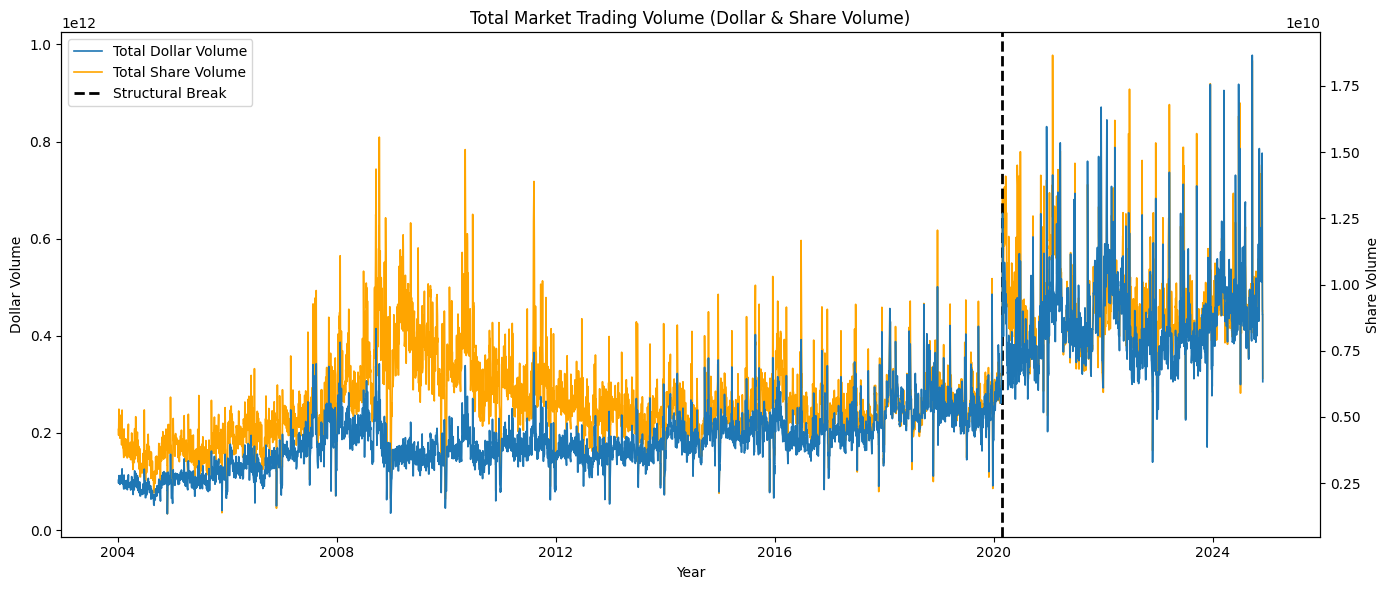

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax2 = ax1.twinx()

# Left axis: dollar volume
l1, = ax1.plot(
    X.index, X["dollar_volume"],
    linewidth=1.2,
    label="Total Dollar Volume",
    zorder=3
)
ax1.set_ylabel("Dollar Volume")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

# Right axis: share volume
l2, = ax2.plot(
    X.index, X["share_volume"],
    linewidth=1.2,
    label="Total Share Volume",
    color="orange",
    zorder=1
)
ax2.set_ylabel("Share Volume")
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

# stack axes so ax1 is on top
ax2.set_zorder(1)
ax1.set_zorder(2)
ax1.patch.set_visible(False)

# Break point
break_dt = pd.Timestamp("2020-02-24")
l3 = ax1.axvline(
    break_dt,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Structural Break"
)

ax1.set_xlabel("Year")

handles = [l1, l2, l3]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("Total Market Trading Volume (Dollar & Share Volume)")
plt.tight_layout()
plt.show()

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

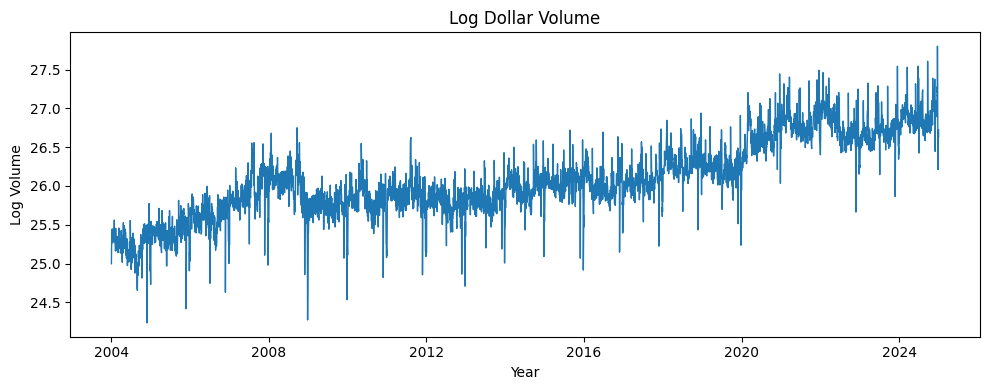

In [6]:
log_dollar_volume = df_dollar["log_total_dollar_volume"]

plt.figure(figsize=(10, 4))
plt.plot(df_dollar.index, log_dollar_volume, lw=1)
plt.title("Log Dollar Volume")
plt.xlabel("Year")
plt.ylabel("Log Volume")
plt.tight_layout()
plt.show()

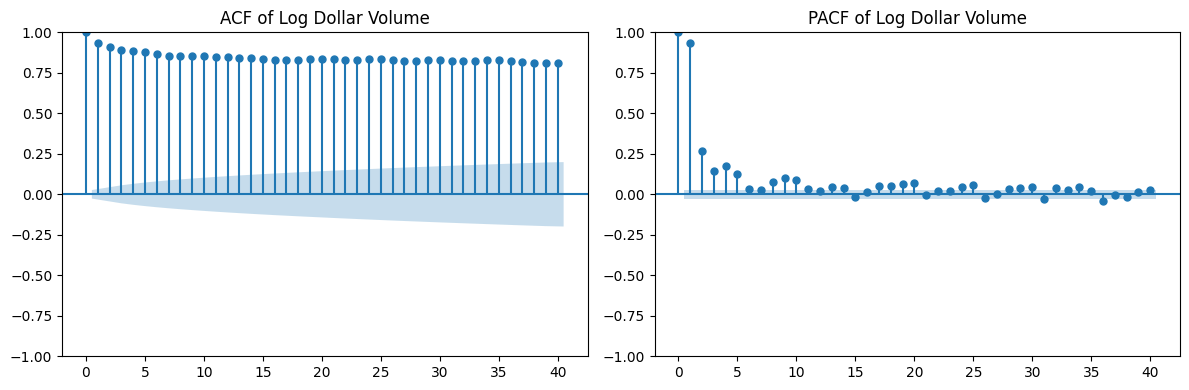

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(log_dollar_volume, lags=40, ax=axes[0])
axes[0].set_title("ACF of Log Dollar Volume")

plot_pacf(log_dollar_volume, lags=40, ax=axes[1], method="ywm")  # stable PACF method
axes[1].set_title("PACF of Log Dollar Volume")

plt.tight_layout()
plt.show()

In [8]:
def adf_and_kpss(series):
    adf = adfuller(series, autolag="AIC")
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(series, regression="c", nlags="auto")
    return adf, kpss_p

In [9]:
adf, kpss_p = adf_and_kpss(log_dollar_volume)
print("Stationarity statistics - Log Dollar Volume")
print(f"ADF p-value: {adf[1]:.3f}")
print(f"KPSS p-value: {kpss_p:.3f}")

Stationarity statistics - Log Dollar Volume
ADF p-value: 0.337
KPSS p-value: 0.010


/var/tmp/ipykernel_25852/3526488652.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(series, regression="c", nlags="auto")


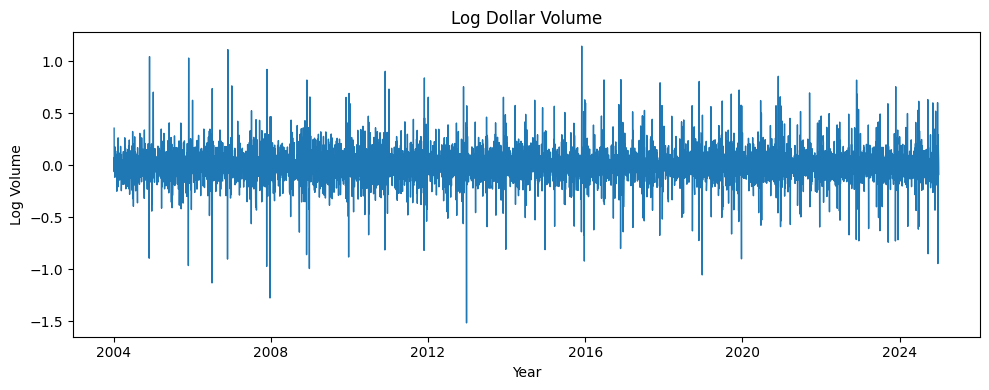

In [14]:
diff_log_dollar_volume = log_dollar_volume.diff().dropna()
plt.figure(figsize=(10, 4))
plt.plot(diff_log_dollar_volume.index, diff_log_dollar_volume, lw=1)
plt.title("Log Dollar Volume")
plt.xlabel("Year")
plt.ylabel("Log Volume")
plt.tight_layout()
plt.show()

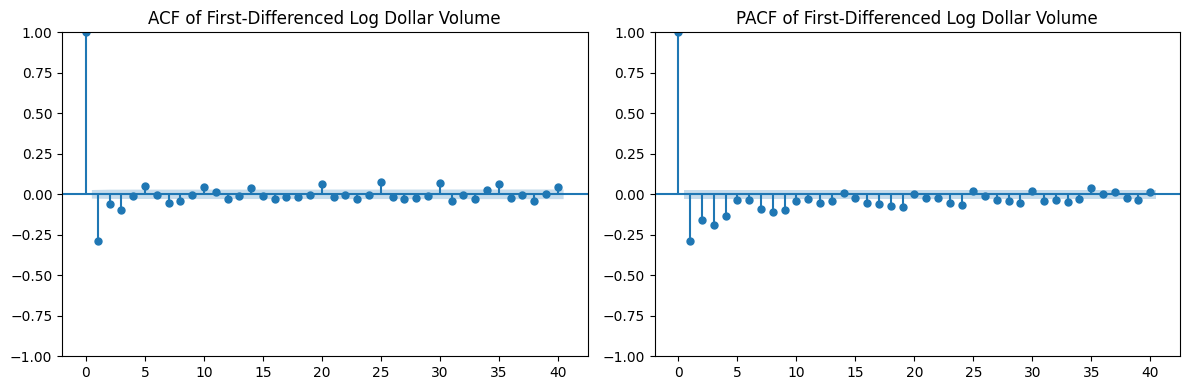

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(diff_log_dollar_volume, lags=40, ax=axes[0])
axes[0].set_title("ACF of First-Differenced Log Dollar Volume")

plot_pacf(diff_log_dollar_volume, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF of First-Differenced Log Dollar Volume")

plt.tight_layout()
plt.show()

In [16]:
adf, kpss_p = adf_and_kpss(diff_log_dollar_volume)
print("Stationarity statistics - First Differenced Log Dollar Volume")
print(f"ADF p-value: {adf[1]:.3f}")
print(f"KPSS p-value: {kpss_p:.3f}")

Stationarity statistics - First Differenced Log Dollar Volume
ADF p-value: 0.000
KPSS p-value: 0.100


/var/tmp/ipykernel_25852/3526488652.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(series, regression="c", nlags="auto")
